In [2]:
import torch
import numpy as np
import time

import sys
import os
import time

import jax
import jax.numpy as jnp

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from neural_net_pytorch import create_train_state_py, train_py, neural_ode_py
import matplotlib.pyplot as plt
from collocation import compute_weights, lagrange_derivative

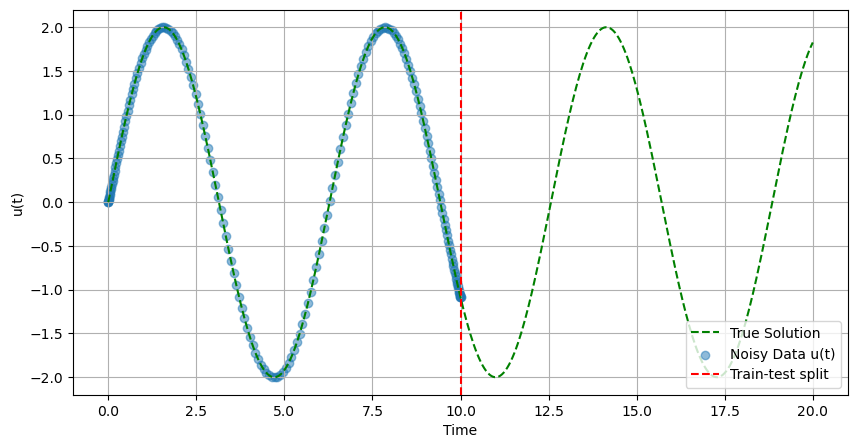

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.0
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [4]:
y0 = np.array([0.0])
layer_widths = [1, 100, 100, 1]
learning_rate = 1e-3

In [5]:
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

t = np.array(t)
y_noisy = np.array(y_noisy)
y_noisy = torch.tensor(y_noisy, dtype=torch.float32)

model, optimizer = create_train_state_py(layer_widths, learning_rate)

start_timer = time.time()
trained_model = train_py(model, optimizer, t, y_noisy, y0, num_epochs = 1000)
end_timer = time.time()
timer = end_timer - start_timer

y_pred = neural_ode_py(trained_model, y0, t)

Epoch 0, Loss: 3.1868536472320557
Epoch 100, Loss: 1.497448444366455
Epoch 200, Loss: 1.4838147163391113
Epoch 300, Loss: 1.5031925439834595
Epoch 400, Loss: 1.7367393970489502
Epoch 500, Loss: 1.8249695301055908
Epoch 600, Loss: 1.8237769603729248
Epoch 700, Loss: 1.8229827880859375
Epoch 800, Loss: 1.8229831457138062
Epoch 900, Loss: 1.8229831457138062


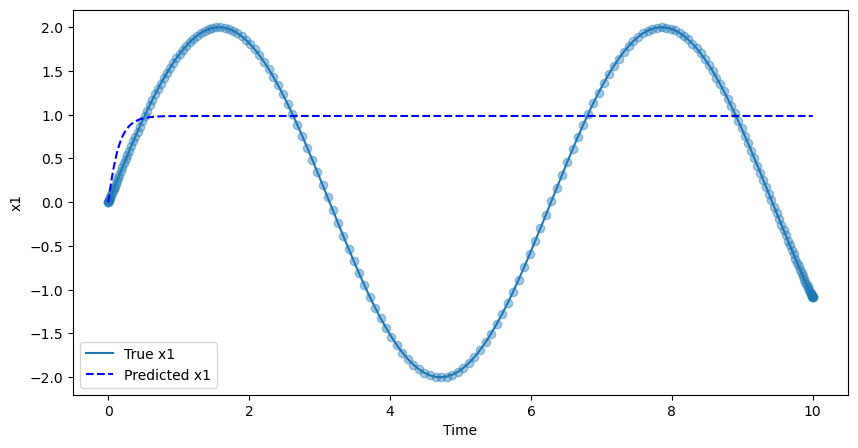

In [8]:
y_pred = neural_ode_py(trained_model, y0, t)
#{"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy": y_noisy.detach().numpy()}

plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], label='True x1')
plt.scatter(t, y_noisy[:, 0], alpha = 0.4)
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')

plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
#mae = np.mean(np.abs(y_pred - y))
# plt.title(f'Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {mae:.4f}; Noise Level: {result["noise_level"]}')
plt.show()